# Import libraries

In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

# Loading the data

In [2]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(datasets.MNIST('./data',
                                                          train=True,
                                                          download=True,
                                                          transform=transforms.Compose([transforms.ToTensor()])),
                                          batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data',
                                                        train=False,
                                                        transform=transforms.Compose([transforms.ToTensor()])),
                                         batch_size=batch_size)

# Defining the model 

In [12]:
class RBM(nn.Module):
    def __init__(self, n_vis=784, n_hin=500, k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin, n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
        
    def sample_from_p(self, p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    #Updating hidden units
    def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v, self.W, self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h, sample_h
    
    #Updating visible units
    def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v, sample_v
    
    def forward(self,v):
        pre_h1, h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
             pre_v, v_ = self.h_to_v(h_)
             pre_h, h_ = self.v_to_h(v_)
             return v, v_
        
    def free_energy(self, v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v, self.W, self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

# Training the model

In [13]:
rbm = RBM(k=3)
train_op = optim.SGD(rbm.parameters(), 0.01)

for epoch in range(2):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1, 784))
        sample_data = data.bernoulli()
        
        v, v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()
        
    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))

Training loss for 0 epoch: -19.218585968017578
Training loss for 1 epoch: -14.246686935424805


# Visualising

In [5]:
def show_img(img):
    img = np.transpose(img.numpy(), (1,2,0))
    plt.imshow(img)

## Real

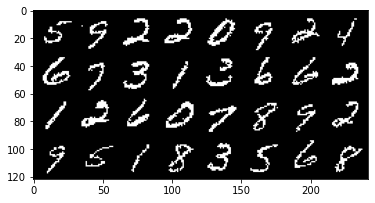

In [6]:
show_img(make_grid(v.view(32, 1, 28, 28).data))

# Generated 

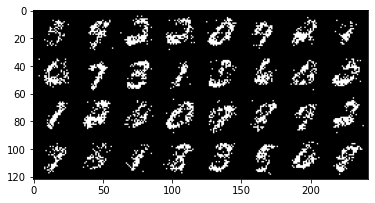

In [7]:
show_img(make_grid(v1.view(32, 1, 28, 28).data))